## Simulate SYSUSD price

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3
import datetime
cwd =  os.getcwd().replace("notebooks/medium_articles","")
os.chdir(cwd)

In [2]:
from uniswappy.math.model import *
from uniswappy.erc import *
from uniswappy.cpt.factory import *
from uniswappy.cpt.factory import *
from uniswappy.process.deposit import *
from uniswappy.process.swap import *
from uniswappy.simulate import SolveDeltas

In [20]:
USER_NM = 'USER_SIM'

def init_amts(tkn_x_amt, p0):
    return tkn_x_amt, p_arr[0,0]*tkn_x_amt 

def create_lp(tkn_x, tkn_y, tkn_x_amt, tkn_y_amt):
    factory = Factory("TKN pool factory", None)
    lp_trial = factory.create_exchange(tkn_x, tkn_y, symbol='LP', address=None)
    lp_trial.add_liquidity(USER_NM, tkn_x_amt, tkn_y_amt, tkn_x_amt, tkn_y_amt)
    return lp_trial

def run(lp_trial, p_trial_arr):
    sDel = SolveDeltas(lp_trial)
    tkn_x = lp_trial.factory.exchange_to_tokens[lp_trial.name][lp_trial.token0]
    tkn_y = lp_trial.factory.exchange_to_tokens[lp_trial.name][lp_trial.token1]
    tkn_price_arr = []
    lp_tot_arr = []
    x_amt_arr = []
    y_amt_arr = []
    for p in p_trial_arr[1:]:      
        swap_dx, swap_dy = sDel.calc(p) # Simulation    
        if(swap_dx >= 0):
            expected_amount_dep = SwapDeposit().apply(lp_trial, tkn_x, USER_NM, abs(swap_dx))
            expected_amount_out = WithdrawSwap().apply(lp_trial, tkn_y, USER_NM, abs(swap_dy))
        elif(swap_dy >= 0):
            expected_amount_dep = SwapDeposit().apply(lp_trial, tkn_y, USER_NM, abs(swap_dy))
            expected_amount_out = WithdrawSwap().apply(lp_trial, tkn_x, USER_NM, abs(swap_dx)) 
        tkn_price_arr.append(lp.get_price(tkn_x))    
        lp_tot_arr.append(lp.total_supply)  
        x_amt_arr.append(lp.get_reserve(tkn_x))  
        y_amt_arr.append(lp.get_reserve(tkn_x))  
    return tkn_price_arr, x_amt_arr    

In [4]:
n_steps = 5000
start_price = 0.1
mu = 0.1; sigma = 0.1
n_paths = 25

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

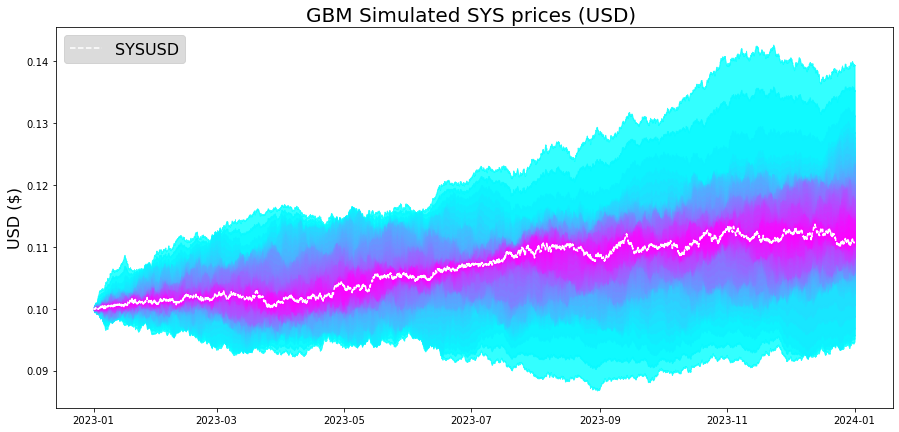

In [15]:
t_deltas = np.linspace(0, 365, num=n_steps+1)
start = datetime.datetime(2023, 1, 1, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=t_delta) for t_delta in t_deltas])  

fig = plt.figure(figsize=(15, 7))
USD_ax = fig.gca()

pymc3.gp.util.plot_gp_dist( 
    ax=USD_ax,
    x=date_times,
    samples=p_arr.transpose(),
    palette='cool',
    plot_samples=False
)

USD_ax.plot(date_times, exp_p_arr, color = 'white',linestyle = 'dashed', label='SYSUSD') 
USD_ax.set_title("GBM Simulated SYS prices (USD) ", fontsize=20)
USD_ax.set_ylabel("USD ($)", fontsize=16)
USD_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')

In [12]:
sys_arr = np.zeros((n_steps, n_paths), np.float64)
lp_tot_arr = np.zeros((n_steps, n_paths), np.float64)

In [21]:
for k in range(n_paths):
    print(f'Trial run {k}')
    p_trial_arr = p_arr[:,k]
    
    tkn = ERC20('TKN', "0x09")
    dai = ERC20('DAI', "0x111")
    
    tkn_x_amt, tkn_y_amt = init_amts(10000, p_trial_arr[0])
    lp = create_lp(tkn, dai, tkn_x_amt, tkn_y_amt)
    sys_arr[:,k], lp_tot_arr[:,k] = run(lp, p_trial_arr)

Trial run 0
Trial run 1
Trial run 2
Trial run 3
Trial run 4
Trial run 5
Trial run 6
Trial run 7
Trial run 8
Trial run 9
Trial run 10
Trial run 11
Trial run 12
Trial run 13
Trial run 14
Trial run 15
Trial run 16
Trial run 17
Trial run 18
Trial run 19
Trial run 20
Trial run 21
Trial run 22
Trial run 23
Trial run 24


Text(0, 0.5, 'DIA')

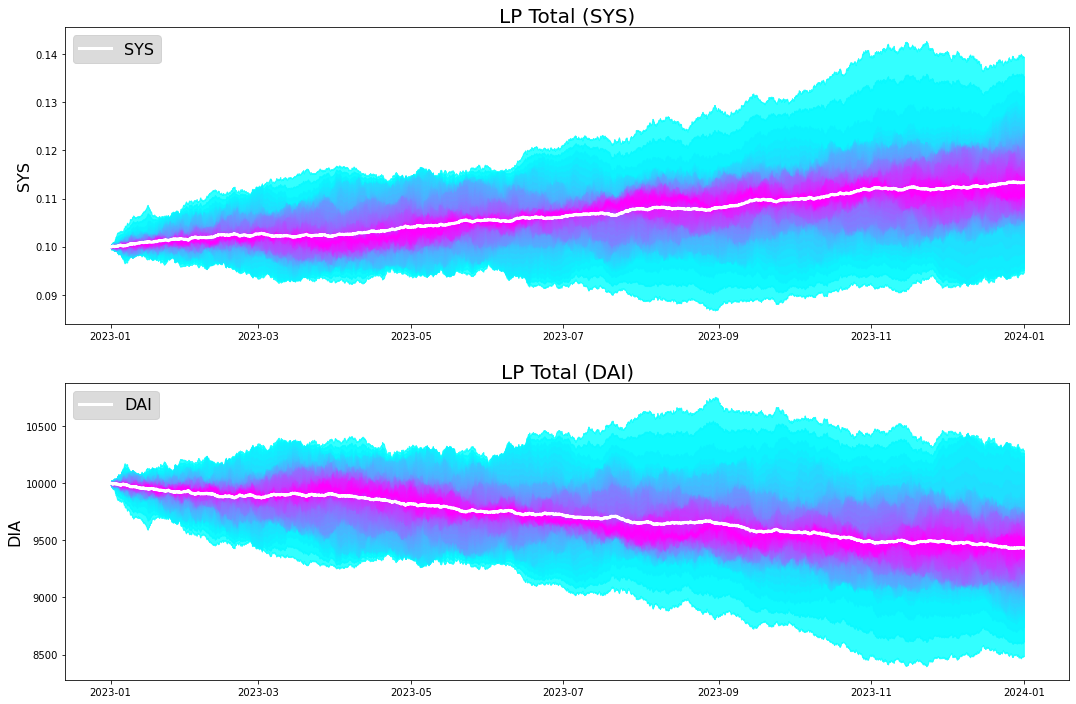

In [22]:
fig, (P_ax, LP_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 12))

pymc3.gp.util.plot_gp_dist( 
    ax=P_ax,
    x=date_times[1:],
    samples=sys_arr.transpose(),
    palette='cool',
    plot_samples=False
)
P_ax.plot(date_times[1:], np.mean(sys_arr, axis = 1), color = 'w', linewidth=3, label='SYS')
P_ax.set_title("LP Total (SYS)", fontsize=20)
P_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
P_ax.set_ylabel("SYS", fontsize=16)

pymc3.gp.util.plot_gp_dist( 
    ax=LP_ax,
    x=date_times[1:],
    samples=lp_tot_arr.transpose(),
    palette='cool',
    plot_samples=False
)
LP_ax.plot(date_times[1:], np.mean(lp_tot_arr, axis = 1), color = 'w', linewidth=3, label='DAI')
LP_ax.set_title("LP Total (DAI)", fontsize=20)
LP_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
LP_ax.set_ylabel("DIA", fontsize=16)




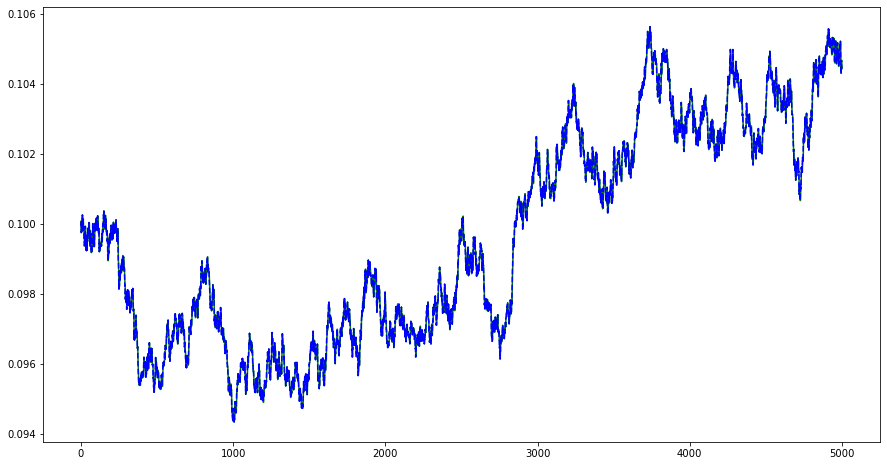

In [23]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(p_trial_arr, color = 'g',linestyle = '-', label='Price (GBM)') 
TKN_ax.plot(tkn_price_arr, color = 'b',linestyle = 'dashed', label='(LP)') 